## Logistic regression using Deep Learning
### (Data is well structured and cleaned)

     Reading Dataset stored in HDF5 format

In [217]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [218]:
hf = h5py.File('//Users//jesuis_monty//Downloads//train_catvnoncat.h5', 'r')
hf1 = h5py.File('//Users//jesuis_monty//Downloads//test_catvnoncat.h5', 'r')

In [219]:
print(str(hf.keys()) +  str(hf1.keys()))

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']><KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>


In [220]:
train_x,train_y =hf.get('train_set_x'),hf.get('train_set_y')
test_x,test_y = hf1.get('test_set_x'),hf1.get('test_set_y')


In [221]:
train_x,train_y,test_x,test_y = np.array(train_x),np.array(train_y),np.array(test_x),np.array(test_y)

In [222]:
hf.close(),hf1.close()

(None, None)

### Data Exploration

In [223]:
m_train = train_x.shape[0]
num_px = train_x.shape[1]
m_test = test_x.shape[0]
train_y = train_y.reshape(1,train_y.shape[0])
test_y = test_y.reshape(1,test_y.shape[0])
print("No. of training examples: "+ str(m_train))
print("Size of Training set: (" + str(m_train)+","+str(num_px)+","+str(num_px)+","+"3)")
print("No. of testing examples: " + str(m_test))
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))


No. of training examples: 209
Size of Training set: (209,64,64,3)
No. of testing examples: 50
train_x shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x shape: (50, 64, 64, 3)
test_y shape: (1, 50)


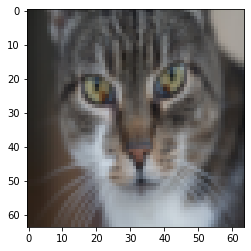

In [224]:
index = 56
plt.imshow(train_x[index])

### Data Preparation for Neural nets model
        - To make computation faster for NN, Normalization is done
        - Normalization center the mean of data and make variance constrain to (-1 to 1)
        - Normalize_x = (mean(x) - x)/std(x)
        - Standardize is also use to center the data but normalization is more beneficial.
        - Normalize helps gradient descent algorithm to update weights more symmetrically.
        - For example if one feature has higher value then weight is updated accordingly
        - Makes other parameter in our case b smaller and make the cost function elongated.
        - thus grad function descent slowly and in zig zag manner.
        - Normalization makes the gradient descent smoothly and straight to local optima instead goin here n there.

In [235]:
# Standardizing data & flatten the shape for implementing vectorization

train_x_vec = train_x.reshape(train_x.shape[0],-1).T
test_x_vec = test_x.reshape(test_x.shape[0],-1).T   # shaping for vectorization

#train_x_vec,test_x_vec = train_x_vec/255,test_x_vec/255 # standardize

# Rather Normalizing the set is more beneficial than standardizing

train_x_vec = (train_x_vec - np.mean(train_x_vec,axis=0,keepdims =True))/np.std(train_x_vec,axis=0,keepdims=True)
test_x_vec = (test_x_vec - np.mean(test_x_vec,axis=0,keepdims =True))/np.std(test_x_vec,axis=0,keepdims=True)

print("Trianing set shape: "+str(train_x_vec.shape)+"  "+ "Testing set shape: " + str(test_x_vec.shape))


Trianing set shape: (12288, 209)  Testing set shape: (12288, 50)


## Building my first neural network (Logistic regression implementation)
### Steps to build
        1 - Initialize the parameters: 
            - Initializing parameter is really an important factor to consider during deep learning.
            - Making parameter large or small makes gradient vanish/exploding problem.
            - Different initialization are Zero, Random, he, xavier etc.
            - Initializing makes difference when you are making deep neural network generally more than 2 layers.
        2 - forward propagation:
            - Added the different activation function for hidden layer : Relu & tanh
            
        3 - compute cost
        4 - Backward propagation:
            - Wrt to Relu activation & tanh activation. 
            
        5 - optimize value (gradient descent)
        6 - Predict using the optimized parameter:
     
     # Regularization is also add to cope with overfitting of data.
    
        

## Helper Functions

In [245]:
# creating Helper function that can use in Main model implementation

# initalize parameter
def initialize_parameter(layer_dim,initialization):
    np.random.seed(1)
    l = len(layer_dim)
    parameters = {}  # dictionary to store values of parameter of each layer
    if(initialization=="zero"):
        for i in range(1,l):
            parameters['W'+ str(i)] = np.zeros((layer_dim[i],layer_dim[i-1])) #Zero initialization
            parameters['b' + str(i)] = np.zeros((layer_dim[i],1))
    if(initialization == "random"):    
        for i in range(1,l):
            parameters['W'+ str(i)] = np.random.randn(layer_dim[i],layer_dim[i-1])*0.1 # Random initialization 
            parameters['b' + str(i)] = np.zeros((layer_dim[i],1))
    if(initialization == "he"):
        for i in range(1,l):
            parameters['W'+ str(i)] = np.random.randn(layer_dim[i],layer_dim[i-1])*np.sqrt(2/layer_dim[i-1]) # 'He' initialization
            parameters['b' + str(i)] = np.zeros((layer_dim[i],1))
        

    return parameters

# Forward propagation function
def forward_prop(X,parameters,activation):
    A = X
    A_prev = A
    cache = ()       # tuple that stores current layer calculated values
    caches = []      # list that stores every layer forward propagation values Z,W,b,A that stores in tuple 'cache'
    L = len(parameters) // 2 # number of layers

    
    # Hidden layer activation calculation based on selected activation:
    for l in range(L-1):            #looping does not include last layer(output layer)
        W = parameters['W'+str(l+1)]
        b = parameters['b'+str(l+1)]
        Z = np.dot(W,A_prev) + b  
        if(activation == "sigmoid"):
            A = 1/(1+np.exp(-Z))
        if(activation == "tanh"):
            A = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
        if(activation == "relu"):
            A = np.maximum(0,Z)
        
        assert(Z.shape == (W.shape[0],X.shape[1]))  # shape of matrix Z should be (hidden_node,training exp)
        assert(A.shape == Z.shape)
        cache = (A,W,Z,b)
        caches.append(cache)   #store each layer calculated values in list, which will be accessed during Back prop
        A_prev = A

    
    # Output layer 'sigmoid' Activation calculation:
    W = parameters['W'+str(L)]
    b = parameters['b'+str(L)]
    Z = np.dot(W,A_prev) + b
    A = 1/(1+np.exp(-Z))
    assert(Z.shape == (W.shape[0],X.shape[1]))
    cache = (A,W,Z,b)   # Assign tuple to current layer values
    caches.append(cache)
    
    
    return caches


# Computation of cost function & adding regularization to provide overfitting:
def compute_cost(AL,Y,parameters,lambd):         
    sum_forbenius_norm = 0
    m = Y.shape[1]
    L = len(parameters) // 2 # number of layers
    if(lambd != 0):
        for l in range(L):
            W = parameters['W'+str(l+1)]
            sum_forbenius_norm = sum_forbenius_norm * np.sum(np.square(W))
           
        L2_cost = (lambd * sum_forbenius_norm)/(2 * m)    
        cost_forward = -(np.dot(Y,np.log(AL.T)) + np.dot(1-Y,np.log((1-AL).T)))/m
        cost = cost_forward + L2_cost
    else:
        cost = -(np.dot(Y,np.log(AL.T)) + np.dot((1-Y),np.log((1-AL).T)))/m
        
    return cost

# Backward Propagation
def back_prop(X,Y,caches,lambd,activation):
    grad = {}
    m = Y.shape[1]
    L = len(caches)         # No. of layers
    AL = caches[L-1][0]     # Activation function of output layer.
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    assert (dAL.shape == AL.shape)
    
    # Output Layer is Sigmoid Activated: Gradient of sigmoid function is calculated
    W = caches[L-1][1]
    b = caches[L-1][3]
    Z = caches[L-1][2]
    A_prev = caches[L-2][0]  # gradient of W requires previous layer Activation function
    part_derv = AL * (1-AL)  # Gradient of sigmoid activation function sigmoid(x) = x(1-x)
    dZ = np.multiply(dAL,part_derv) # dZ = g[L]'(Z[L]) * dAL
    grad['db' + str(L)] = (1./m) * np.sum(dZ,axis=1,keepdims =True)
    grad['dW' + str(L)] = (1./m * (np.dot(dZ,A_prev.T))) + np.multiply((lambd/m),W)
    dAL = np.dot(W.T,dZ)        # Output of Backprop dAL-1
    assert (dZ.shape == Z.shape)
    assert (grad['dW' + str(L)].shape == W.shape)
    assert (grad['db' + str(L)].shape == b.shape)
        
        
        
    # Hidden Layer Gradient calculation based on selected activation 
    for l in reversed(range(L-1)):
        AL = caches[l][0]                 # Current layer activation value
        W = caches[l][1]
        b = caches[l][3]
        Z = caches[l][2]
        
        if activation == "sigmoid":
            part_derv = np.multiply(AL,1-AL)     # part_derv = dAL/dZ
        elif activation == "tanh":
            part_derv = 1-np.power(AL,2)
        elif activation == "relu":
            part_derv = np.int64(AL > 0)
            
        if(l!=0): 
            A_prev = caches[l-1][0] # previous layer activation value
        else: 
            A_prev = X     
          
        dZ = np.multiply(dAL,part_derv)
        assert (dZ.shape == Z.shape)
        grad['db' + str(l+1)] = 1./m * np.sum(dZ,axis=1,keepdims =True)
        grad['dW' + str(l+1)] = (1./m * np.dot(dZ,A_prev.T))  + np.multiply((lambd/m),W)
        assert (grad['dW' + str(l+1)].shape == W.shape)
        assert (grad['db' + str(l+1)].shape == b.shape)
        dAL = np.dot(W.T,dZ)
        assert (dAL.shape == A_prev.shape)
        
    return grad 

# update parameter
def update_parm(learning_rate,parameters,grad):
    L = len(grad)//2
    for l in range(L):
        parameters['W'+str(l+1)] = parameters['W'+str(l+1)] - learning_rate * grad['dW'+str(l+1)]
        parameters['b'+str(l+1)] = parameters['b'+str(l+1)] - learning_rate * grad['db'+str(l+1)]
           
    return parameters

# prediction

def predict(parameters,X,activation):
    cache = forward_prop(X,parameters,activation)
    AL = cache[len(cache)-1][0]
    prediction = (AL>0.5)
    
    return prediction

## Gradient Check 

In [237]:
def dictionary_to_vector(x):
    # x -- Dictionary that you want to convert
    result =[]
    for key in x:
        temp = x[key].reshape(-1,1).tolist()
        result = result + temp
        
    result = np.array(result)
    return result


def vector_to_dict(x,y,type):
    # x -- Vector
    # y -- dict to convert back into, to get the key to map with vector value.
    dic = {}
    l = len(y)//2
    w_count_prev = 0
    b_count_prev = 0
    for i in range(l):
        if(type == 'parameters'):
            typ_W,typ_b = 'W','b'
        else:
            typ_W,typ_b = 'dW','db'
            
        W_count = y[typ_W +str(i+1)].shape[0] * y[typ_W+str(i+1)].shape[1]
        b_count = y[typ_b +str(i+1)].shape[0] * y[typ_b+str(i+1)].shape[1]
    
        dic[typ_W +str(i+1)] = x[w_count_prev:W_count+w_count_prev].reshape(y[typ_W+str(i+1)].shape[0],y[typ_W+str(i+1)].shape[1])
        dic[typ_b +str(i+1)] = x[W_count+w_count_prev:W_count+w_count_prev+b_count].reshape(y[typ_b+str(i+1)].shape[0],1)
        w_count_prev = W_count+w_count_prev+b_count
        
    return dic    
    

In [238]:
def gradient_check(parameters,grad,epsilon,X,Y):
    parameter_values = dictionary_to_vector(parameters)
    grad_values = dictionary_to_vector(grad)
    num_parameters = parameter_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))

    for i in range(num_parameters):
        thetaplus = np.copy(parameter_values)

        thetaplus[i][0] = thetaplus[i][0] + epsilon

        cache= forward_prop(X,vector_to_dict(thetaplus,parameters,'parameters'),"relu")
        AL = cache[len(cache)-1][0]
        cost = compute_cost(AL,Y,parameters,0)
        J_plus[i][0] = cost
        thetaminus = np.copy(parameter_values)                                    
        thetaminus[i][0] =  thetaminus[i][0] - epsilon                                     
        cache= forward_prop(X,vector_to_dict(thetaminus,parameters,'parameters'),"relu")
        AL = cache[len(cache)-1][0]
        cost = compute_cost(AL,Y,parameters,0)
        J_minus[i][0] = cost
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)

    print(J_plus)
    numerator =  np.linalg.norm(grad_values-gradapprox)
    denominator = np.linalg.norm(grad_values) + np.linalg.norm(gradapprox)
    difference = numerator/denominator

    if difference > (2 * epsilon):
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    

In [239]:
# Main model
def LR_NN(X,Y,layered_dim,learning_rate,iteration,initialization,lambd,activation):
    np.random.seed(1)
    parm = initialize_parameter(layered_dim,initialization)
    costs = []
    # Gradient Descent
    for i in range(iteration):
        caches_layerwise = forward_prop(X,parm,activation)
        AL = caches_layerwise[len(caches_layerwise)-1][0]
        cost = compute_cost(AL,Y,parm,lambd)
        if(i%100==0): 
            print(" Cost after "+ str(i)+" iterations: "+ str(cost))
            costs.append(cost)
        grad_layerwise = back_prop(X,Y,caches_layerwise,lambd,activation)
        parm = update_parm(learning_rate,parm,grad_layerwise)     # update parm
           
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    predictions = predict(parm,X,activation)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} Layered NN: {} %".format(len(layered_dim)-1, accuracy))
    
    return parm,accuracy,predictions  

 Cost after 0 iterations: [[1.78474496]]
 Cost after 100 iterations: [[0.38789333]]
 Cost after 200 iterations: [[0.31534427]]
 Cost after 300 iterations: [[0.26058688]]
 Cost after 400 iterations: [[0.21593243]]
 Cost after 500 iterations: [[0.18165039]]
 Cost after 600 iterations: [[0.15354375]]
 Cost after 700 iterations: [[0.13114907]]
 Cost after 800 iterations: [[0.11193419]]
 Cost after 900 iterations: [[0.09616575]]
 Cost after 1000 iterations: [[0.08420713]]
 Cost after 1100 iterations: [[0.07270859]]
 Cost after 1200 iterations: [[0.06523133]]
 Cost after 1300 iterations: [[0.05692419]]
 Cost after 1400 iterations: [[0.05111214]]
 Cost after 1500 iterations: [[0.04523744]]
 Cost after 1600 iterations: [[0.04095655]]
 Cost after 1700 iterations: [[0.03715982]]
 Cost after 1800 iterations: [[0.03377132]]
 Cost after 1900 iterations: [[0.03112547]]
 Cost after 2000 iterations: [[0.02870964]]
 Cost after 2100 iterations: [[0.02682567]]
 Cost after 2200 iterations: [[0.02471232]]


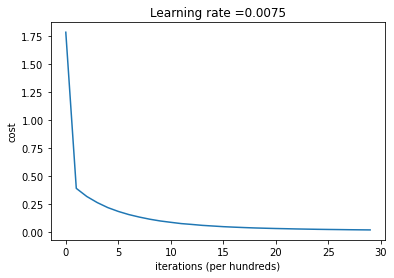

Accuracy for 4 Layered NN: 100.0 %


In [254]:
n = [12288, 20, 7, 5, 1] # layer dimension
parm,train_accuracy,predict_y = LR_NN(train_x_vec,train_y,n,0.0075,3000,"he",0.4,"relu")

In [255]:
# Test_set accuracy
predictions = predict(parm,test_x_vec,"relu")

accuracy = float((np.dot(test_y,predictions.T) + np.dot(1-test_y,1-predictions.T))/float(test_y.size)*100)
print ("Train Set Accuracy for {} Layered NN: {} %".format(len(n)-1, train_accuracy))
print ("Test Set Accuracy for {} Layered NN: {} %".format(len(n)-1, accuracy))

Train Set Accuracy for 4 Layered NN: 100.0 %
Test Set Accuracy for 4 Layered NN: 72.0 %
